In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, pickle, time, sys
import mne
import scipy.stats as ss
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
from utils import *
# %matplotlib qt
import neurokit2 as nk
from scipy.stats import entropy
# from scipy import stats
from pyentrp import entropy as ent
from scipy.signal import welch, find_peaks, savgol_filter
from pyentrp import entropy as ent
from scipy.stats import moment
from scipy.signal import butter, lfilter
# from PyEMD import EMD
import pywt
import nolds
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = (10,8)
from tqdm.notebook import tqdm

In [2]:
def read_emg_csv(parent_folder, folder, subfolder):
    path = os.path.join(parent_folder, folder, "Myo", subfolder, "EMG.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        # markers = df[' Marker'].unique()
        # # print(markers)
        # # count = df[' Marker'].value_counts()
        # # print(count)
        data = {}
        myo_elctrodes = [' Electrode 1', ' Electrode 2', ' Electrode 3',' Electrode 4', ' Electrode 5', ' Electrode 6', ' Electrode 7', ' Electrode 8']
        for i , (dir, s,e) in enumerate(zip(['Y' , 'Z', 'X'],[1000, 2000, 3000], [1001, 2001, 3001])):
            start_row_indices = df[df[' Marker'] == s].index
            end_row_indices = df[df[' Marker'] == e].index
            data[f'TskDir_{dir}'] = []
            for start, end in zip(start_row_indices, end_row_indices):
                data[f'TskDir_{dir}'].append(df.iloc[start + 1: end][myo_elctrodes].values)
        # print(f"Successfully read EMG.csv in {os.path.join(parent_folder, folder, 'Myo', subfolder)}")
        return data
    else:
        # print(f"EMG.csv not found in {os.path.join(parent_folder, folder, 'Myo', subfolder)}")
        return None
    
parent_folder_path = 'D:/VIP_MRTK3/EMG_Data/ismar2023/Experimental_Database'
subfolder_names = ["ControllerAndPen", "TwoControllers", "TwoHand"]
EMG_Dataset = {}
for folder in os.listdir(parent_folder_path):
    if os.path.isdir(os.path.join(parent_folder_path, folder)):
        EMG_Dataset[f'{folder}'] = {}
        for subfolder in subfolder_names:
            EMG_Dataset[f'{folder}'][f'{subfolder}'] = read_emg_csv(parent_folder_path, folder, subfolder)
            
print(EMG_Dataset.keys())       
print(EMG_Dataset['P11_Data'].keys())
print(EMG_Dataset['P11_Data']['TwoControllers'].keys())

dict_keys(['P01_Data', 'P02_Data', 'P03_Data', 'P04_Data', 'P05_Data', 'P06_Data', 'P07_Data', 'P08_Data', 'P09_Data', 'P10_Data', 'P11_Data', 'P12_Data', 'P13_Data', 'P14_Data', 'P15_Data', 'P16_Data', 'P17_Data', 'P18_Data', 'P19_Data', 'P20_Data', 'P21_Data', 'P22_Data', 'P23_Data', 'P24_Data', 'P25_Data'])
dict_keys(['ControllerAndPen', 'TwoControllers', 'TwoHand'])
dict_keys(['TskDir_Y', 'TskDir_Z', 'TskDir_X'])


In [41]:
#================================================================================
#                            [Butter Bandpass]
#================================================================================
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


#================================================================================
#                            [Willison Amplitude]
#================================================================================
def cal_willison_amplitude(emg_data, threshold=0.1):
    'emg shape: [pnts, channel]'
    diff_data = np.diff(emg_data, axis=0)
    wamp = np.sum(np.abs(diff_data) > threshold, axis=0)
    return wamp


#================================================================================
#                            [Simple Square Integral]
#================================================================================
def cal_simple_square_integral(emg_data):
    'emg shape: [pnts, channel]'
    ssi = np.sum(emg_data ** 2, axis=0)
    return ssi


#================================================================================
#                            [Integrated EMG]
#================================================================================
def cal_integrated_emg(emg_data):
    'emg shape: [pnts, channel]'
    iemg = np.sum(np.abs(emg_data), axis=0)
    return iemg


#================================================================================
#                            [Mean Absolute Value]
#================================================================================

def cal_mav(emg_data):
    'emg shape: [pnts, channel]'
    mav = np.mean(np.abs(emg_data), axis=0)
    return mav


#================================================================================
#                            [Root Mean Square]
#================================================================================
def cal_root_mean_square(emg_data):
    'emg shape: [pnts, channel]'
    rms = np.sqrt(np.mean(emg_data ** 2, axis=0))
    return rms


#================================================================================
#                            [Median Frequency]
#================================================================================
def cal_median_frequency(emg_data, fs=200, nperseg=200):
    'emg shape: [pnts, channel]'
    mdf = []
    for elec_idx in range(emg_data.shape[1]):
        electrode_data = emg_data[:, elec_idx]
        freqs, Pxx = welch(electrode_data, fs, nperseg=nperseg)
        cumsum = np.cumsum(Pxx)
        median_freq = freqs[np.where(cumsum >= cumsum[-1] / 2)[0][0]]
        mdf.append(median_freq)
    mdf = np.array(mdf)
    return mdf


#================================================================================
#                            [Mean Frequency]
#================================================================================
def cal_mean_frequency(emg_data, fs=200, nperseg=200):
    'emg shape: [pnts, channel]'
    mnf = []
    for elec_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, elec_idx], fs, nperseg=nperseg)
        mnf.append(np.sum(f * Pxx) / np.sum(Pxx))
    mnf = np.array(mnf)
    return mnf


#================================================================================
#                            [Peak Frequency]
#================================================================================
def cal_peak_frequency(emg_data, fs=200, nperseg=200):
    'emg shape: [pnts, channel]'
    pkf = []
    for ch_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, ch_idx], fs, nperseg=nperseg)
        pkf.append(f[np.argmax(Pxx)])
    pkf = np.array(pkf)
    return pkf


#================================================================================
#                            [Mean Power]
#================================================================================
def cal_mean_power(emg_data, fs=200, nperseg=200):
    mnp = []
    for ch_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, ch_idx], fs, nperseg=nperseg)
        mnp.append(np.mean(Pxx))

    mnp = np.array(mnp)
    return mnp


#================================================================================
#                            [Total Power]
#================================================================================
def cal_total_power(emg_data, fs=200, nperseg=200):
    ttp = []
    for ch_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, ch_idx], fs, nperseg=nperseg)
        ttp.append(np.sum(Pxx))
    ttp = np.array(ttp)

    return ttp


#================================================================================
#                            [Waveform Lenght]
#================================================================================
def cal_waveform_length(emg_data):
    'emg shape: [pnts, channel]'
    wl = np.sum(np.abs(np.diff(emg_data, axis=0)), axis=0)
    return wl


#================================================================================
#                            [Sample Entropy]
#================================================================================
def cal_sample_entropy(emg_data, m=2, r=0.2):
    'emg shape: [pnts, channel]'
    sentropy = []
    for elec_idx in range(emg_data.shape[1]):
        se = ent.sample_entropy(emg_data[:, elec_idx], m, r)
        sentropy.append(se[-1])  # Use the last value (m = 2)
    return np.array(sentropy)


#================================================================================
#                            [Slop Sign Change]
#================================================================================
def cal_slope_sign_changes(emg_data):
    'emg shape: [pnts, channel]'
    diff_data = np.diff(emg_data, axis=0)
    ssc = np.sum((diff_data[:-1, :] * diff_data[1:, :]) < 0, axis=0)
    return ssc


#================================================================================
#                            [Zero Crossing Rate]
#================================================================================
def cal_zero_crossing_rate(emg_data):
    'emg shape: [pnts, channel]'
    zcr = np.sum((emg_data[:-1, :] * emg_data[1:, :]) < 0, axis=0)
    return zcr


#================================================================================
#                            [Hjorth]
#================================================================================
def cal_hjorth_parameters(emg_data):
    'emg shape: [pnts, channel]'
    first_derivative = np.diff(emg_data, axis=0)
    second_derivative = np.diff(first_derivative, axis=0)

    activity = np.mean(emg_data ** 2, axis=0)
    mobility = np.mean(first_derivative ** 2, axis=0) / activity
    complexity = (np.mean(second_derivative ** 2, axis=0) / np.mean(first_derivative ** 2, axis=0)) / mobility

    return activity, mobility, complexity


#================================================================================
#                            [Spectral Moments]
#================================================================================
def cal_spectral_moments(emg_data, fs=200, nperseg=200):
    'emg shape: [pnts, channel]'
    mean_frequency, variance_frequency = [], []

    for elec_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, elec_idx], fs=fs, nperseg=nperseg)
        mean_freq = np.sum(f * Pxx) / np.sum(Pxx)
        mean_frequency.append(mean_freq)
        variance_frequency.append(moment(Pxx, moment=2))

    mean_frequency = np.array(mean_frequency)
    variance_frequency = np.array(variance_frequency)

    return mean_frequency, variance_frequency


#================================================================================
#                            [Wavelet Transform]
#================================================================================

def cal_wavelet_transform(emg_data, wavelet='db4'):
    'emg shape: [pnts, channel]'

    wavelet_coeffs_list = pywt.wavedec(emg_data, wavelet, axis=0)

    return wavelet_coeffs_list


#================================================================================
#                            [Deterended Fluctuations Analysis]
#================================================================================

def cal_detrended_fluctuation_analysis(emg_data):
    'emg shape: [pnts, channel]'
    dfa = []
    for elec_idx in range(emg_data.shape[1]):
        dfa.append(nolds.dfa(emg_data[:, elec_idx]))
    return np.array(dfa)


#================================================================================
#                            [Windowing]
#================================================================================

def window_emg_data(emg_data, fs, window_length, overlap=0):
    'emg shape: [pnts, channel]'
    num_samples, num_electrodes = emg_data.shape
    window_length = int(window_length * fs)
    overlap = int(overlap * fs)
    step_size = window_length - overlap
    num_windows = (num_samples - overlap) // step_size

    windowed_emg_data = np.empty((window_length, num_windows, num_electrodes))

    for win_idx in range(num_windows):
        start_sample = win_idx * step_size
        end_sample = start_sample + window_length
        windowed_emg_data[:, win_idx, :] = emg_data[start_sample:end_sample, :]
    return windowed_emg_data


#================================================================================
#                            [Plot EMG]
#================================================================================

def plot_emg(data_list, fig_size=(12, 8), scale=1.01, ylim=None):
    'data is a list of inputs with shape of [pnts, channel]'

    channel = data_list[0].shape[1]
    channel_max = 0.0
    fig, ax = plt.subplots(channel, 1, sharex=True, figsize=fig_size)
    for i in range(channel):
        for j in range(len(data_list)):
            data = data_list[j]
            ax[i].plot(data[:, i], linewidth=0.5)
            if ylim is None:
                channel_max_cur = np.max(np.abs(data[:, i])) * scale
                if channel_max_cur > channel_max:
                    channel_max = channel_max_cur
                ax[i].set_ylim(-channel_max, channel_max)
            else:
                ax[i].set_ylim(ylim[0], ylim[1])
            ax[i].set_ylabel(f'Channel {i + 1}')
            if i == channel - 1:
                ax[i].set_xlabel('Time')
    plt.tight_layout()
    plt.show()


#================================================================================
#                            [EMG Trend]
#================================================================================ 

def regressor(data, fs=200, regressor='linear', plot_trend=False):
    'data shape: [pnts, channel]'
    time = np.arange(0, len(data))
    num_channels = data.shape[1]

    regression_models, regression_slopes = [], []
    for i in range(num_channels):
        channel_data = data[:, i].reshape(-1, 1)
        time_reshaped = time.reshape(-1, 1)

        if regressor == 'linear':
            # linear regressor
            model = LinearRegression()
            model.fit(time_reshaped, channel_data)
            regression_models.append(model)
            regression_slopes.append(model.coef_[0])

        elif regressor == 'svr':
            # Support vector regressor 
            model = SVR(kernel='rbf', C=1e3, gamma=0.1)
            model.fit(time_reshaped, channel_data.ravel())
            regression_models.append(model)

        elif regressor == 'rf':
            # RF regressor 
            model = RandomForestRegressor(n_estimators=100, random_state=0)
            model.fit(time_reshaped, channel_data.ravel())
            regression_models.append(model)
        else:
            raise 'TypeError' "current regressors are 'linear' | 'svr' | 'rf'"

    # Visualize the fitted regression curves
    # fitted_curve = np.array([model.predict(time_reshaped).squeeze() for model in regression_models])
    # plot_emg([data, fitted_curve.T])
    if plot_trend:
        if num_channels == 1:
            fig, ax = plt.subplots(figsize=(10, 5))
            axs = [ax]
        else:
            fig, axs = plt.subplots(num_channels, 1, figsize=(10, 5 * num_channels))

        # fig, axs = plt.subplots(num_channels, 1, figsize=(10, 5 * num_channels))
        for i, model in enumerate(regression_models):
            channel_data = data[:, i]
            fitted_curve = model.predict(time_reshaped)

            axs[i].plot(time, channel_data, label='EMG Channel {}'.format(i + 1))
            axs[i].plot(time, fitted_curve, label='Fitted Regression Curve', linestyle='--')
            axs[i].set_xlabel('Time (s)')
            axs[i].set_ylabel('Amplitude')
            axs[i].legend()

        plt.tight_layout()
        plt.show()

    return np.array(regression_slopes)[:, 0]


#================================================================================
#                            [WCF Estimator]
#================================================================================ 
def cal_wcf(emg_data, window_func=np.hanning):
    """
    Calculate the Weighted Cumulative Frequency (WCF) Estimator for EMG data.
    :param emg_data: 3D numpy array of EMG data (samples, windows, channels)
    :param window_func: Window function to be used for windowing
    :return: WCF estimates for each window and channel
    """
    num_samples, num_windows, num_channels = emg_data.shape
    wcf = np.empty((num_windows, num_channels))

    # calculate gamma for each channel
    gamma = np.zeros(num_channels)
    for channel in range(num_channels):
        first_window_data = emg_data[:, 0, channel] * window_func(num_samples)
        first_window_fft = np.fft.fft(first_window_data)
        gamma[channel] = np.sqrt(np.sum((num_samples - np.arange(1, num_samples)) *
                                        (np.abs(first_window_fft[1:]) ** 2)) / (num_samples - 1))

        if gamma[channel] < 0.0001:
            print(f'gamma too small for channel {channel + 1}')

    # calculate wcf for each window and channel
    for channel in range(num_channels):
        for window_id in range(num_windows):
            window_data = emg_data[:, window_id, channel]
            # apply window function
            windowed_data = window_data * window_func(num_samples)
            # calculate fft
            dft_window = np.fft.fft(windowed_data, axis=0)
            dft_magnitude_squared = np.abs(dft_window[1:]) ** 2
            # calculate wcf 
            wcf_cur = np.sqrt(
                np.sum((num_samples - np.arange(1, num_samples)) * dft_magnitude_squared) / (num_samples - 1))
            wcf[window_id, channel] = 2 * (window_id + 1) - (1 / gamma[channel]) * wcf_cur

    return wcf


#================================================================================
#                            [WCW Estimator]
#================================================================================ 
def cal_wcw(emg_data, wavelet_name='sym5'):
    """
    Calculate the Weighted-Cumulated Wavelet (WCW) Estimator for EMG data.

    :param emg_data: 3D numpy array of EMG data (samples, windows, channels)
    :param wavelet_name: Name of the wavelet to be used for decomposition
    :return: WCW estimates for each window and channel
    """
    num_samples, num_windows, num_channels = emg_data.shape
    max_levels = int(np.log2(num_samples))
    wcw_estimates = np.zeros((num_windows, num_channels))

    for channel in range(num_channels):
        # Wavelet decomposition of the first window to calculate gamma
        first_data = emg_data[:, 0, channel]
        first_wavelet_coeffs = pywt.wavedec(first_data, wavelet_name, level=max_levels - 1)
        gamma = np.sqrt(sum(sum(abs(coeff) ** 2) / (2 ** l) for l, coeff in enumerate(first_wavelet_coeffs)))

        for window in range(num_windows):
            # Wavelet decomposition for each window
            data = emg_data[:, window, channel]
            wavelet_coeffs = pywt.wavedec(data, wavelet_name, level=max_levels - 1)

            # Calculating the weighted cumulative sum of wavelet coefficients
            lambda_W_sum = sum(sum(abs(coeff) ** 2) / (2 ** l) for l, coeff in enumerate(wavelet_coeffs))
            # WCW estimate for the current window
            lambda_W_r = 2 * (window + 1) - (1 / gamma) * np.sqrt(lambda_W_sum)
            wcw_estimates[window, channel] = lambda_W_r

    return wcw_estimates




#================================================================================
#                            [WCR Estimator]
#================================================================================ 
def cal_wcr(emg_data):
    """
    Calculate the Weighted Cumulative Root Mean Square (WCR) Estimator for EMG data.
    
    :param emg_data: 3D numpy array of EMG data (samples, windows, channels)
    :return: WCR estimates for each window and channel
    """
    num_samples, num_windows, num_channels = emg_data.shape
    wcr = np.zeros((num_windows, num_channels))

    # Calculating lambda_r for each channel
    for channel in range(num_channels):
        # Calculate gamma for the channel
        gamma = np.sqrt(np.sum(emg_data[:, 0, channel] ** 2) / num_samples)

        # Check if gamma is too small to avoid division by zero
        if gamma < 0.0001:
            print(f'Gamma value too small for channel {channel + 1}, calculations may be inaccurate.')
            continue

        # Calculate lambda_r for each window in the channel
        for window in range(num_windows):
            # computes the cumulative root mean square for windows up to the current one
            sum_sqrt = np.sum([np.sqrt(np.sum(emg_data[:, m, channel] ** 2) / num_samples) for m in range(window + 1)])
            wcr[window, channel] = 2 * (window + 1) - (
                        1 / gamma) * sum_sqrt  # window+1 is used to match the formula where window index starts from 1

    return wcr


#================================================================================
#                            [WCZ Estimator]
#================================================================================ 
def cal_wcz(emg_data):
    """
    Calculate the Weighted Cumulative Zero-Crossings (WCZ) Estimator for EMG data.
    
    :param emg_data: 3D numpy array of EMG data (samples, windows, channels)
    :return: WCZ estimates for each window and channel
    """
    num_samples, num_windows, num_channels = emg_data.shape
    wcz = np.zeros((num_windows, num_channels))

    for channel in range(num_channels):
        for window in range(num_windows):
            # Count zero crossings in the data for the current window and channel
            data = emg_data[:, window, channel]
            zero_crossings = np.where(np.diff(np.sign(data)))[0]  # Identify indices where zero crossings occur
            num_zero_crossings = len(zero_crossings)

            # Calculate gamma for the channel (using the first window)
            if window == 0:
                gamma = num_zero_crossings / num_samples

            # Calculate lambda_Z for each window in the channel
            lambda_Z = sum([np.where(np.diff(np.sign(emg_data[:, w, channel])))[0].size for w in range(window + 1)]) / (
                        num_samples * gamma)
            wcz[window, channel] = lambda_Z

    return wcz


#================================================================================
#                            [WCM Estimator]
#================================================================================ 
def cal_wcm(emg_data, sampling_rate=200):
    """
    Calculate the Weighted Cumulative Median Frequency (WCM) Estimator for EMG data.
    
    :param emg_data: 3D numpy array of EMG data (samples, windows, channels)
    :param sampling_rate: Sampling rate of the EMG data
    :return: WCM estimates for each window and channel
    """
    num_samples, num_windows, num_channels = emg_data.shape
    wcm = np.zeros((num_windows, num_channels))

    for channel in range(num_channels):
        mdf_values = []

        for window in range(num_windows):
            data = emg_data[:, window, channel]
            # Calculate power spectrum using Welch's method
            freqs, power_spectrum = welch(data, fs=sampling_rate, nperseg=len(data))

            # Calculate the median frequency (MDF) of the spectrum
            cumulative_sum = np.cumsum(power_spectrum)
            total_power = cumulative_sum[-1]
            median_freq_index = np.where(cumulative_sum >= total_power / 2)[0][0]
            mdf = freqs[median_freq_index]
            mdf_values.append(mdf)

        gamma = mdf_values[0]

        for window in range(num_windows):
            # Calculate lambda_M for each window
            lambda_m = sum(mdf_values[:window + 1]) / gamma
            wcm[window, channel] = lambda_m

    return wcm

In [71]:
records = []
# Iterate over subjects
for subject, subject_data in EMG_Dataset.items():
    # Iterate over objects
    for object_name, object_data in subject_data.items():
        # Iterate over directions
        for direction, direction_data in object_data.items():
            # Iterate over repetitions
            for repetition in range(4):
                
                # read data
                x = EMG_Dataset[subject][object_name][direction][repetition]
                # print(f'input data: {x.shape}')
                
                # preprocessing
                x_f = butter_bandpass_filter(x, fs=200, lowcut=20, highcut=90)
                # x_rect = np.abs(x_f)
                # x_smooth = savgol_filter(x_rect, window_length=10, polyorder=2, axis=0, mode='interp')
                maximum_voluntary_contraction = np.max(x_f, axis=0)
                # print(maximum_voluntary_contraction)
                x_norm = x_f/maximum_voluntary_contraction
                x_p = x_norm         # change what kinf of data you want to use for process[raw | normalized| Rectified]
                
                # Windowing
                win_len = 0.2
                # print(f'max win_len is {x.shape[0]/200}')
                overlap = 0.1
                if win_len is None:
                    x_win = x_p[:, None, :]
                else:
                    x_win = window_emg_data(x_p, fs=200, window_length=win_len, overlap=overlap)
                # print(x_win.shape)
                
                # Feature Extraction
                x_feature = []
                for i in range (x_win.shape[1]):
                    # mav = cal_mav(x_win[:,i,:])
                    # mnf = cal_mean_frequency(x_win[:,i,:], fs=200, nperseg=x_win.shape[0])
                    # mdf = cal_median_frequency(x_win[:,i,:], fs=200, nperseg=x_win.shape[0])
                    rms = cal_root_mean_square(x_win[:,i,:])
                    x_feature.append(rms)
                  
                # regressor line slope inside each repeation
                if x_win.shape[1]>1:
                    # print('windowed features')
                    # x_feature = regressor(np.array(x_feature), plot_trend=False)[None,:]
                    x_feature = np.mean(np.array(x_feature), axis=0, keepdims=True)
                    # x_feature = np.median(np.array(x_feature), axis=0, keepdims=True)
                else:
                    # print('non-windowed features')
                    x_feature = np.array(x_feature)
                    
                # print(x_feature.shape)
                
                record = {
                    'Subject': subject,
                    'Object': object_name,
                    'Direction': direction,
                    'Repetition': repetition+1,
                    'Channel1': x_feature[0,0],
                    'Channel2': x_feature[0,1],
                    'Channel3': x_feature[0,2],
                    'Channel4': x_feature[0,3],
                    'Channel5': x_feature[0,4],
                    'Channel6': x_feature[0,5],
                    'Channel7': x_feature[0,6],
                    'Channel8': x_feature[0,7],
                    'ChannelAvg': np.mean(x_feature)
                }
                records.append(record)

df = pd.DataFrame(records)
df

,Subject,Object,Direction,Repetition,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,ChannelAvg
0,P01_Data,ControllerAndPen,TskDir_Y,1,0.209054,0.098547,0.181731,0.082836,0.159033,0.176030,0.243165,0.228493,0.172361
1,P01_Data,ControllerAndPen,TskDir_Y,2,0.101298,0.133027,0.121417,0.135557,0.176517,0.192652,0.190799,0.157185,0.151057
2,P01_Data,ControllerAndPen,TskDir_Y,3,0.125930,0.068028,0.113060,0.104402,0.216214,0.108201,0.194241,0.188022,0.139762
3,P01_Data,ControllerAndPen,TskDir_Y,4,0.112875,0.092859,0.154862,0.157816,0.150410,0.219120,0.219668,0.231574,0.167398
4,P01_Data,ControllerAndPen,TskDir_Z,1,0.210780,0.116603,0.132690,0.173351,0.205236,0.153545,0.216562,0.190063,0.174854
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,P25_Data,TwoHand,TskDir_Z,4,0.122443,0.179790,0.184328,0.140846,0.115526,0.168518,0.177996,0.296825,0.173284
896,P25_Data,TwoHand,TskDir_X,1,0.172170,0.233293,0.225469,0.178728,0.178680,0.234398,0.217752,0.187331,0.203478
897,P25_Data,TwoHand,TskDir_X,2,0.132451,0.227729,0.192549,0.137515,0.127772,0.244433,0.217597,0.227970,0.188502
898,P25_Data,TwoHand,TskDir_X,3,0.198903,0.232340,0.216726,0.198115,0.198315,0.184479,0.136672,0.197905,0.195432


In [72]:
df['Object'] = df['Object'].map({'ControllerAndPen':'Pen', 'TwoControllers':'Controller', 'TwoHand':'Hand'})
df['Direction'] = df['Direction'].map({'TskDir_X':'X', 'TskDir_Y':'Y', 'TskDir_Z':'Z'})
df[(df['Direction'] == 'X') & (df['Object'] == 'Pen')]

,Subject,Object,Direction,Repetition,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,ChannelAvg
8,P01_Data,Pen,X,1,0.228279,0.167244,0.243382,0.168839,0.189555,0.186720,0.202484,0.284784,0.208911
9,P01_Data,Pen,X,2,0.227674,0.093677,0.130818,0.110040,0.110877,0.189086,0.255711,0.239530,0.169677
10,P01_Data,Pen,X,3,0.247811,0.192528,0.168920,0.245163,0.237546,0.206450,0.219021,0.191268,0.213589
11,P01_Data,Pen,X,4,0.260600,0.229868,0.176452,0.227533,0.274381,0.202663,0.187968,0.223353,0.222852
44,P02_Data,Pen,X,1,0.175008,0.186348,0.177930,0.181758,0.172437,0.189499,0.155557,0.235508,0.184256
...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,P24_Data,Pen,X,4,0.292660,0.275587,0.243322,0.310098,0.280416,0.188155,0.228277,0.282543,0.262632
872,P25_Data,Pen,X,1,0.179597,0.213755,0.200925,0.153631,0.186902,0.241446,0.230089,0.240210,0.205820
873,P25_Data,Pen,X,2,0.168615,0.244546,0.221579,0.185632,0.184452,0.229001,0.199517,0.238610,0.208994
874,P25_Data,Pen,X,3,0.159427,0.184533,0.175124,0.168791,0.182089,0.198449,0.277628,0.329270,0.209414


## Replace RMS with WCF


In [76]:
records = []
# Iterate over subjects
for subject, subject_data in EMG_Dataset.items():
    # Iterate over objects
    for object_name, object_data in subject_data.items():
        # Iterate over directions
        for direction, direction_data in object_data.items():
            # Iterate over repetitions
            for repetition in range(4):

                # read data
                x = EMG_Dataset[subject][object_name][direction][repetition]
                # print(f'input data: {x.shape}')

                # preprocessing
                x_f = butter_bandpass_filter(x, fs=200, lowcut=20, highcut=90)
                # x_rect = np.abs(x_f)
                # x_smooth = savgol_filter(x_rect, window_length=10, polyorder=2, axis=0, mode='interp')
                maximum_voluntary_contraction = np.max(x_f, axis=0)
                x_norm = x_f/maximum_voluntary_contraction
                x_p = x_norm        # change what kinf of data you want to use for process[raw | normalized| Rectified]
                # print(x_p.shape)

                # Windowing
                win_len = 0.2
                # print(f'max win_len is {x.shape[0]/200}')
                overlap = 0.1
                if win_len is None:
                    x_win = x_p[:, None, :]
                else:
                    x_win = window_emg_data(x_p, fs=200, window_length=win_len, overlap=overlap)
                # print(x_win.shape)

                # Feature Extraction
                # TODO: Replace RMS with WCF
                x_feature = []
                    # print(f'wcf: {wcf.shape}')
                    # x_feature.append(wcf)
                
                wcf = cal_wcf(x_win, window_func=np.hanning)
                # print(f'wcf: {wcf.shape}')
                # print(wcf)
                x_feature.append(wcf)
                # print(f'x_feature: {np.array(x_feature).shape}')

                # regressor line slope inside each repeation
                if x_win.shape[1]>1:
                    # print('windowed features')
                    # x_feature = regressor(np.array(x_feature), plot_trend=False)[None,:]
                    x_feature = np.mean(np.array(x_feature), axis=0, keepdims=True)
                    # x_feature = np.median(np.array(x_feature), axis=0, keepdims=True)
                else:
                    # print('non-windowed features')
                    x_feature = np.array(x_feature)

                # print(x_feature.shape)
                x_feature_squeezed = np.squeeze(x_feature)
                channels_data_lists = [x_feature_squeezed[:, channel].tolist() for channel in range(x_feature.shape[2])]

                # for channel, channel_data_list in enumerate(channels_data_lists, start=1):
                #     print(f"Channel {channel} data:", channel_data_list)

                record = {
                    'Subject': subject,
                    'Object': object_name,
                    'Direction': direction,
                    'Repetition': repetition+1,
                    'Channel1': channels_data_lists[0],
                    'Channel2': channels_data_lists[1],
                    'Channel3': channels_data_lists[2],
                    'Channel4': channels_data_lists[3],
                    'Channel5': channels_data_lists[4],
                    'Channel6': channels_data_lists[5],
                    'Channel7': channels_data_lists[6],
                    'Channel8': channels_data_lists[7],
                    'ChannelAvg': np.mean(x_feature_squeezed)
                }
                records.append(record)

df = pd.DataFrame(records)
df

,Subject,Object,Direction,Repetition,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,ChannelAvg
0,P01_Data,ControllerAndPen,TskDir_Y,1,"[1.0, 2.935158845601486, 5.14724209866886, 6.8...","[1.0, 3.506095154563742, 5.666764269480321, 7....","[1.0, 2.7803484144343846, 5.0972485779114685, ...","[1.0, 3.5758535359166435, 5.6442488607599755, ...","[1.0, 3.4747547494679525, 5.472547260490263, 7...","[1.0, 3.18367019481404, 5.091910802145356, 7.2...","[1.0, 3.1891669181000637, 5.264609181030259, 7...","[1.0, 3.207484329421487, 5.100829754044603, 7....",238.580121
1,P01_Data,ControllerAndPen,TskDir_Y,2,"[1.0, 3.0385741081386435, 5.265156412716267, 7...","[1.0, 2.766603832120145, 5.143883684782841, 7....","[1.0, 3.069841759148966, 5.260941784010946, 7....","[1.0, 2.779990416355843, 5.111622757197485, 7....","[1.0, 3.1125374160934562, 5.189907565723605, 7...","[1.0, 3.1767986112739024, 5.086680232632077, 7...","[1.0, 3.1962489334653092, 5.312222263260224, 7...","[1.0, 3.0514093497118586, 4.970709954869914, 6...",240.421065
2,P01_Data,ControllerAndPen,TskDir_Y,3,"[1.0, 3.0996224776868737, 4.419753448995223, 5...","[1.0, 2.5170500636902142, 1.6199920636081986, ...","[1.0, 3.100068602511961, 4.398333601227861, 6....","[1.0, 2.362040199627609, 0.9670184313460375, 4...","[1.0, 2.6643847602223643, 4.501244067502791, 6...","[1.0, 2.668776367324928, 3.1911712202795917, 5...","[1.0, 2.4565775272616586, 4.418409581527691, 6...","[1.0, 2.8993246398004047, 4.3587445562767115, ...",251.049902
3,P01_Data,ControllerAndPen,TskDir_Y,4,"[1.0, 3.1957299990848558, 5.393880750528485, 7...","[1.0, 3.3752175747403927, 5.249367536782057, 7...","[1.0, 3.22642808784377, 5.436964876608239, 7.5...","[1.0, 3.274917182179531, 5.107313237261333, 7....","[1.0, 3.0004071276666244, 4.622924434662681, 7...","[1.0, 2.657752262024858, 4.479421779021157, 6....","[1.0, 2.731156322150919, 4.395893027564547, 6....","[1.0, 2.61167283655831, 4.059073012585272, 7.0...",280.320347
4,P01_Data,ControllerAndPen,TskDir_Z,1,"[1.0, 3.54169418104175, 5.5515048684050345, 7....","[1.0, 3.5118265936742707, 5.579474319212762, 7...","[1.0, 3.5656188820083754, 5.579216088889328, 7...","[1.0, 3.45117077287217, 5.483823740682159, 7.1...","[1.0, 3.2281277818203282, 5.288876847707311, 6...","[1.0, 2.890466209422355, 5.203854639292731, 6....","[1.0, 3.1781101296673278, 5.245551441850118, 7...","[1.0, 2.6566137044147933, 5.150317880192594, 7...",242.513059
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,P25_Data,TwoHand,TskDir_Z,4,"[1.0, 2.8488238476740886, 4.946216286251443, 6...","[1.0, 2.7722083715272356, 5.118149893627388, 6...","[1.0, 2.81257414166038, 4.8753251997626865, 6....","[1.0, 2.6301701795730423, 5.094762234866779, 6...","[1.0, 2.913361562524309, 4.965004579187672, 6....","[1.0, 3.311312332796753, 4.925513249560886, 6....","[1.0, 3.3378267519551312, 5.04887519946614, 7....","[1.0, 3.3705014487204243, 5.052956876268373, 7...",52.752987
896,P25_Data,TwoHand,TskDir_X,1,"[1.0, 2.8804888068536196, 3.995796028756952, 5...","[1.0, 2.91025022315191, 3.9082165246218468, 5....","[1.0, 2.9833638826238964, 4.165347416826976, 6...","[1.0, 3.0312505201957416, 4.1754583217684935, ...","[1.0, 3.177515613995939, 4.758505715982121, 6....","[1.0, 2.767067901806999, 4.803978353429173, 6....","[1.0, 2.4883332668530063, 4.48210377985671, 6....","[1.0, 2.630852873420233, 3.9737895227814937, 6...",46.285427
897,P25_Data,TwoHand,TskDir_X,2,"[1.0, 3.015429799557406, 5.1254865000290835, 7...","[1.0, 2.8589611990281907, 4.943938798572307, 7...","[1.0, 3.1101019246675143, 5.131529557617227, 7...","[1.0, 2.9733846764415786, 4.84291638745641, 7....","[1.0, 3.2024525316554477, 5.0472711071922, 7.3...","[1.0, 3.372512315285461, 5.437376523960888, 7....","[1.0, 2.115576006673114, 4.686627657930111, 6....","[1.0, 3.277609148957704, 5.233379809490218, 7....",55.740876
898,P25_Data,TwoHand,TskDir_X,3,"[1.0, 3.146910527370898, 5.0253778453383795, 6...","[1.0, 3.130163371421223, 5.06434971

## Replace RMS with WCW

In [4]:
records = []
# Iterate over subjects
for subject, subject_data in EMG_Dataset.items():
    # Iterate over objects
    for object_name, object_data in subject_data.items():
        # Iterate over directions
        for direction, direction_data in object_data.items():
            # Iterate over repetitions
            for repetition in range(4):

                # read data
                x = EMG_Dataset[subject][object_name][direction][repetition]
                # print(f'input data: {x.shape}')

                # preprocessing
                x_f = butter_bandpass_filter(x, fs=200, lowcut=20, highcut=90)
                # x_rect = np.abs(x_f)
                # x_smooth = savgol_filter(x_rect, window_length=10, polyorder=2, axis=0, mode='interp')
                maximum_voluntary_contraction = np.max(x_f, axis=0)
                x_norm = x_f/maximum_voluntary_contraction
                x_p = x_norm        # change what kinf of data you want to use for process[raw | normalized| Rectified]
                # print(x_p.shape)

                # Windowing
                win_len = 0.2
                # print(f'max win_len is {x.shape[0]/200}')
                overlap = 0.1
                if win_len is None:
                    x_win = x_p[:, None, :]
                else:
                    x_win = window_emg_data(x_p, fs=200, window_length=win_len, overlap=overlap)
                # print(x_win.shape)

                # Feature Extraction
                # TODO: Replace RMS with WCW
                x_feature = []
                # for i in range (x_win.shape[2]):
                #     # mav = cal_mav(x_win[:,i,:])
                #     # mnf = cal_mean_frequency(x_win[:,i,:], fs=200, nperseg=x_win.shape[0])
                #     # mdf = cal_median_frequency(x_win[:,i,:], fs=200, nperseg=x_win.shape[0])
                #     # rms = cal_root_mean_square(x_win[:,i,:])
                #     # print(f'x_win[:,:,i]: {x_win[:,:,i].shape}')
                #     # print(f'x_win[:,i,:]: {x_win[:,i,:].shape}')
                #     wcf = cal_wcf_single_channel(x_win[:,:,i], window_func=np.hanning) 
                # print(f'wcf: {wcf.shape}')
                # x_feature.append(wcf)

                wcw = cal_wcw(x_win)
                # print(f'wcw: {wcw.shape}')
                # print(wcw)
                x_feature.append(wcw)
                # print(f'x_feature: {np.array(x_feature).shape}')

                # regressor line slope inside each repeation
                if x_win.shape[1]>1:
                    # print('windowed features')
                    # x_feature = regressor(np.array(x_feature), plot_trend=False)[None,:]
                    x_feature = np.mean(np.array(x_feature), axis=0, keepdims=True)
                    # x_feature = np.median(np.array(x_feature), axis=0, keepdims=True)
                else:
                    # print('non-windowed features')
                    x_feature = np.array(x_feature)

                # print(x_feature.shape)
                x_feature_squeezed = np.squeeze(x_feature)
                channels_data_lists = [x_feature_squeezed[:, channel].tolist() for channel in range(x_feature.shape[2])]

                # for channel, channel_data_list in enumerate(channels_data_lists, start=1):
                #     print(f"Channel {channel} data:", channel_data_list)

                record = {
                    'Subject': subject,
                    'Object': object_name,
                    'Direction': direction,
                    'Repetition': repetition+1,
                    'Channel1': channels_data_lists[0],
                    'Channel2': channels_data_lists[1],
                    'Channel3': channels_data_lists[2],
                    'Channel4': channels_data_lists[3],
                    'Channel5': channels_data_lists[4],
                    'Channel6': channels_data_lists[5],
                    'Channel7': channels_data_lists[6],
                    'Channel8': channels_data_lists[7],
                    'ChannelAvg': np.mean(x_feature_squeezed)
                }
                records.append(record)

df = pd.DataFrame(records)
df

C:\Users\Richard\AppData\Local\Programs\Python\Python39\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


,Subject,Object,Direction,Repetition,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,ChannelAvg
0,P01_Data,ControllerAndPen,TskDir_Y,1,"[[-0.9999999999999999, 0.7408735160714921, 2.9...","[[-1.0, 1.530356028369703, 3.635662368838207, ...","[[-1.0, 1.4607677739990423, 3.528462177270184,...","[[-0.9999999999999999, 1.734598577608362, 3.78...","[[-1.0, -0.16294441092151146, 2.29469712875328...","[[-1.0, 1.8554941583719653, 3.8409807787032655...","[[-1.0, 1.857974831596019, 3.8770748903113046,...","[[-1.0, 1.913055632261726, 3.8423278927733913,...",3.139409
1,P01_Data,ControllerAndPen,TskDir_Y,2,"[[-1.0, 1.1125632373785082, 3.1545838849313004...","[[-0.9999999999999999, 0.7772424767258013, 2.9...","[[-1.0, 1.2926292341016992, 3.2656825871010247...","[[-1.0, 0.6659935578249505, 2.831995977921422,...","[[-1.0, 1.818243603541951, 3.768674873756934, ...","[[-1.0, 1.947216308927456, 3.9264302892006917,...","[[-1.0, 1.9453094376377713, 3.8977444666479713...","[[-1.0, 1.879764144618208, 3.8543372235477804,...",3.167852
2,P01_Data,ControllerAndPen,TskDir_Y,3,"[[-1.0, 1.9088762819854326, 3.699591315026679,...","[[-1.0, 1.4349982031097288, 3.0896154092627475...","[[-1.0, 1.7507134668615243, 3.2282865160718934...","[[-0.9999999999999999, 1.8234050278035925, 3.5...","[[-1.0, 1.5943479703779437, 3.643102258943949,...","[[-1.0, 1.9182404621223355, 3.7417699389836336...","[[-1.0, 1.7143461897830279, 3.6019088526106655...","[[-1.0, 1.0906048764160334, 3.221224817679011,...",3.120293
3,P01_Data,ControllerAndPen,TskDir_Y,4,"[[-1.0, 1.7657505933575541, 3.6674118901613983...","[[-1.0, 1.8650593471679286, 3.6045940845128865...","[[-1.0, 1.7977156979216804, 3.6936066439277804...","[[-1.0, 1.9426110669172036, 3.7607625640015914...","[[-0.9999999999999999, 1.8098391379001952, 3.6...","[[-1.0, 1.3181074221729205, 3.387203854428334,...","[[-1.0, 1.6629860399079022, 3.53857573696741, ...","[[-1.0, 1.8832326526462684, 3.9000641519191324...",3.146080
4,P01_Data,ControllerAndPen,TskDir_Z,1,"[[-1.0, 1.7906581388470801, 3.815797785440688,...","[[-1.0, 1.7713335661954361, 3.8669737167355946...","[[-1.0, 1.6955621770882976, 3.684683624883058,...","[[-1.0, 1.7444427487706964, 3.853695827706781,...","[[-1.0, 1.2759954881488895, 2.6317197371786643...","[[-1.0, 1.8711361381096632, 3.8576300413488838...","[[-0.9999999999999999, 1.5635293865126196, 3.6...","[[-1.0, 1.902893144474576, 3.8895846804187686,...",3.162704
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,P25_Data,TwoHand,TskDir_Z,4,"[[-1.0, 1.900436478441737, 3.8839554809919385,...","[[-1.0, 1.8690183209776692, 3.83369883008898, ...","[[-1.0, 1.9026567923224482, 3.8930062884815264...","[[-1.0, 1.8817275161320623, 3.8681976638294286...","[[-1.0, 1.8402083189409908, 3.869323309050898,...","[[-1.0, 1.6358572621899299, 3.1468243149617487...","[[-1.0, 0.8006152886083253, 2.4336732126171974...","[[-1.0, 1.8678379845867448, 3.7884559096475114...",3.156647
896,P25_Data,TwoHand,TskDir_X,1,"[[-1.0, 1.944285644639714, 3.936214763867955, ...","[[-1.0, 1.9198633169214017, 3.9107831042930674...","[[-1.0, 1.9508089257549623, 3.9532102686021666...","[[-1.0, 1.9289534247501132, 3.9102672509349894...","[[-1.0, 1.7679010163219866, 3.744457201907843,...","[[-1.0, 0.39602737436981705, 1.570455377995101...","[[-1.0, 1.9292985432013778, 3.9093215050800727...","[[-1.0, 1.8221634722586817, 3.738075540633053,...",3.028236
897,P25_Data,TwoHand,TskDir_X,2,"[[-1.0, 1.7199126821685011, 3.69508107508246, ...","[[-1.0, 1.1600798115176711, 3.0942489418174883...","[[-1.0, 1.6577890153545156, 3.6195100335747274...","[[-1.0, 1.0020197184359139, 3.0994319174132414...","[[-1.0, 1.1247057591994254, 3.02586384943782, ...","[[-1.0, 1.9564818136714153, 3.837072218590736,...","[[-0.9999999999999999, 1.767709808431721, 3.37...","[[-0.9999999999999999, 1.9314334232580992, 3.9...",3.138667
898,P25_Data,TwoHand,TskDir_X,3,"[[-1.0, 1.8522241867773361, 3.8957116431728793...","[[-1.0, 1.8895317642833271, 3.9397798271471474..

In [68]:
df['Object'] = df['Object'].map({'ControllerAndPen':'Pen', 'TwoControllers':'Controller', 'TwoHand':'Hand'})
df['Direction'] = df['Direction'].map({'TskDir_X':'X', 'TskDir_Y':'Y', 'TskDir_Z':'Z'})
df[(df['Direction'] == 'X') & (df['Object'] == 'Pen')]

,Subject,Object,Direction,Repetition,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,ChannelAvg
8,P01_Data,Pen,X,1,0.228279,0.167244,0.243382,0.168839,0.189555,0.186720,0.202484,0.284784,0.208911
9,P01_Data,Pen,X,2,0.227674,0.093677,0.130818,0.110040,0.110877,0.189086,0.255711,0.239530,0.169677
10,P01_Data,Pen,X,3,0.247811,0.192528,0.168920,0.245163,0.237546,0.206450,0.219021,0.191268,0.213589
11,P01_Data,Pen,X,4,0.260600,0.229868,0.176452,0.227533,0.274381,0.202663,0.187968,0.223353,0.222852
44,P02_Data,Pen,X,1,0.175008,0.186348,0.177930,0.181758,0.172437,0.189499,0.155557,0.235508,0.184256
...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,P24_Data,Pen,X,4,0.292660,0.275587,0.243322,0.310098,0.280416,0.188155,0.228277,0.282543,0.262632
872,P25_Data,Pen,X,1,0.179597,0.213755,0.200925,0.153631,0.186902,0.241446,0.230089,0.240210,0.205820
873,P25_Data,Pen,X,2,0.168615,0.244546,0.221579,0.185632,0.184452,0.229001,0.199517,0.238610,0.208994
874,P25_Data,Pen,X,3,0.159427,0.184533,0.175124,0.168791,0.182089,0.198449,0.277628,0.329270,0.209414


# Standalone testing block


In [45]:
import numpy as np
import scipy.signal


# Generating test data
np.random.seed(0)
test_sampling_rate = 200  # Hz
test_emg_data = np.random.randn(256, 10, 2)  # 256 samples, 10 windows, 2 channels

# Calculate WCF, WCW, WCR, WCZ, WCM
wcf_test_results = cal_wcf(test_emg_data, window_func=np.hanning)
wcw_test_results = cal_wcw(test_emg_data)
wcr_test_results = cal_wcr(test_emg_data)
wcz_test_results = cal_wcz(test_emg_data)
wcm_test_results = cal_wcm(test_emg_data, test_sampling_rate)

d = {
    'WCF': list(wcf_test_results),
    'WCW': list(wcw_test_results),
    'WCR': list(wcr_test_results),
    'WCZ': list(wcz_test_results),
    'WCM': list(wcm_test_results)
}

df = pd.DataFrame(data=d)
df




C:\Users\Richard\AppData\Local\Programs\Python\Python39\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


,WCF,WCW,WCR,WCZ,WCM
0,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"
1,"[3.0248682896174506, 2.9685470615426937]","[3.4142616437990596, 2.433252320136988]","[2.041466760081729, 1.9171850324350075]","[2.040983606557377, 2.1196581196581197]","[2.0923076923076924, 2.109375]"
2,"[5.111632946747005, 5.021410764848462]","[4.557101620131026, 4.7227329995716705]","[3.102626953760983, 2.831703768267803]","[3.098360655737705, 3.1880341880341883]","[3.1846153846153844, 3.25]"
3,"[7.130781530795127, 6.916884201123519]","[7.524121169264433, 7.471407801168943]","[4.227595165550398, 3.699965721649912]","[4.008196721311475, 4.273504273504273]","[4.0, 4.109375]"
4,"[9.050829411930353, 8.983667700485851]","[8.983055098963943, 8.329897204832118]","[5.251029088769998, 4.6451435035834825]","[4.983606557377049, 5.3076923076923075]","[5.046153846153846, 5.1875]"
5,"[11.116294700137033, 11.032200480998332]","[11.42276525582117, 10.734628094534687]","[6.331236487619926, 5.609326976389155]","[6.155737704918033, 6.3931623931623935]","[6.123076923076923, 6.234375]"
6,"[13.029810097205647, 13.065621722513951]","[13.436157779173275, 12.259435578247246]","[7.378351097854392, 6.590320473662805]","[7.270491803278689, 7.589743589743589]","[7.3538461538461535, 7.25]"
7,"[15.053290633351448, 15.018466914884966]","[15.00935338291211, 13.981027676526905]","[8.37937387602722, 7.575917319820757]","[8.295081967213115, 8.709401709401709]","[8.307692307692308, 8.296875]"
8,"[17.155106610004538, 17.02968420823505]","[17.074441788821144, 17.201467370445414]","[9.483108517275008, 8.56218882090743]","[9.352459016393443, 9.820512820512821]","[9.246153846153845, 9.1875]"
9,"[19.02505187867664, 19.046717614949472]","[19.12139526684413, 19.200188383103658]","[10.498642807747988, 9.566328205424533]","[10.237704918032787, 10.948717948717949]","[10.0, 10.234375]"


In [95]:
# import matplotlib.pyplot as plt

# def plot_features(df, subject_id, object_id, direction):
#     subject_data = df[(df['Subject'] == subject_id) & (df['Object'] == object_id) & (df['Direction'] == direction)]
#     # assuming 'rms', 'mav', 'mnf', 'mdf' columns are averages of all channels
#     # for feature in ['rms', 'mav', 'mnf', 'mdf']:
#     plt.figure(figsize=(10, 4))
#     plt.plot(subject_data['ChannelAvg'])
#     plt.title(f'ChannelAvg for subject {subject_id}, object {object_id}, direction {direction}')
#     plt.xlabel('repetition')
#     plt.ylabel('ChannelAvg')
#     plt.show()

# # call the function
# plot_features(df, subject_id='P19_Data', object_id='Pen', direction='Y')

### Primary Visualization of data


In [73]:
directions = ['X', 'Y', 'Z']
# channels = ['Channel1', 'Channel2', 'Channel3', 'Channel4', 'Channel5', 'Channel6', 'Channel7', 'Channel8', 'ChannelAvg']
channels = ['ChannelAvg']


plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2})

for direction in directions:
    for channel in channels:
        # print(f'dir: {direction} | ch: {channel}')
        plt.figure(figsize=(10,6))
        # Setting the overall style of the plot
        sns.set_style("whitegrid")
        sns.lineplot(data=df[df['Direction'] == direction], x='Repetition', y=channel, hue='Object', errorbar=None,estimator=np.mean, palette='viridis')
        
        for i in range(len(df[df['Direction'] == direction])):
            plt.text(i, df[df['Direction'] == direction][channel].iloc[i], 
                     round(df[df['Direction'] == direction][channel].iloc[i], 2), horizontalalignment='center', size='small', color='black', weight='semibold')
        
        
        plt.title(f'Average extracted RMS values Over Time in {direction} Direction',fontsize=14)
        #plt.title(f'Average extracted WCF values Over Time in {direction} Direction',fontsize=14)
        plt.xlabel('Repetition', fontsize=12)
        plt.ylabel(f'Average RMS Value', fontsize=12)
        # plt.ylabel(f'Average WCF Value', fontsize=12)
        plt.legend(title='Object', title_fontsize='12', loc='upper right')
        plt.tight_layout()
        plt.show()

C:\Users\Richard\AppData\Local\Temp\ipykernel_16528\782312717.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


ValueError: Image size of 70266x1642 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x600 with 1 Axes>

C:\Users\Richard\AppData\Local\Temp\ipykernel_16528\782312717.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


ValueError: Image size of 70266x1777 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x600 with 1 Axes>

C:\Users\Richard\AppData\Local\Temp\ipykernel_16528\782312717.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


ValueError: Image size of 70266x2001 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x600 with 1 Axes>

### T-test

Explain the results: This is explanaition for the Slope for RMS data

Following table displays the results of pairwise t-tests between the three objects (Pen, Controller, and Hand) for each repetition and direction. The t-tests compare the average RMS slopes (i.e., rates of fatigue) for different objects. Here's an interpretation of the results:

* Direction X: In the first repetition, the slope of RMS values (i.e., the rate of fatigue) is significantly different when comparing the Controller and Hand, with a lower mean slope for the Controller (negative t-statistic). This pattern also holds true for the second, fifth, seventh, and eighth repetitions. However, in the seventh repetition, the slope for the Pen is significantly higher than that of the Controller (positive t-statistic). In the eighth repetition, the slope for the Pen is significantly lower than that of the Hand.

* Direction Y: Here, the Hand shows significantly higher fatigue rates than the Pen in the first, third, fourth, fifth, sixth, and eighth repetitions (negative t-statistics). The Controller also shows significantly higher fatigue rates than the Hand in the third, fourth, sixth, and eighth repetitions. In the fifth repetition, the Pen shows a significantly higher fatigue rate than the Controller.

* Direction Z: In the fifth and ninth repetitions, the Pen shows a significantly higher fatigue rate than the Controller.

These results suggest that the rate of muscular fatigue, as measured by the slope of RMS values, varies significantly depending on the object used and the direction of the task. In general, the Hand seems to exhibit higher rates of fatigue (higher RMS slopes), particularly when compared to the Pen or Controller in certain directions and repetitions.(Strange)

   Direction     Channel  Repetition          Comparison    t_stat     p_val
0          X  ChannelAvg           1   Pen vs Controller -2.236721  0.029986
1          X  ChannelAvg           2   Pen vs Controller -2.684750  0.009934
2          X  ChannelAvg           2  Controller vs Hand  3.172469  0.002636
3          X  ChannelAvg           3   Pen vs Controller -4.390448  0.000062
4          X  ChannelAvg           3  Controller vs Hand  4.280445  0.000089
5          X  ChannelAvg           4   Pen vs Controller -4.129334  0.000144
6          X  ChannelAvg           4  Controller vs Hand  3.750824  0.000475
7          X  ChannelAvg           5   Pen vs Controller -3.848909  0.000350
8          X  ChannelAvg           5  Controller vs Hand  3.113894  0.003110
9          X  ChannelAvg           6   Pen vs Controller -3.324275  0.001704
10         X  ChannelAvg           6  Controller vs Hand  2.947458  0.004934
11         X  ChannelAvg           7   Pen vs Controller -2.427033  0.019026

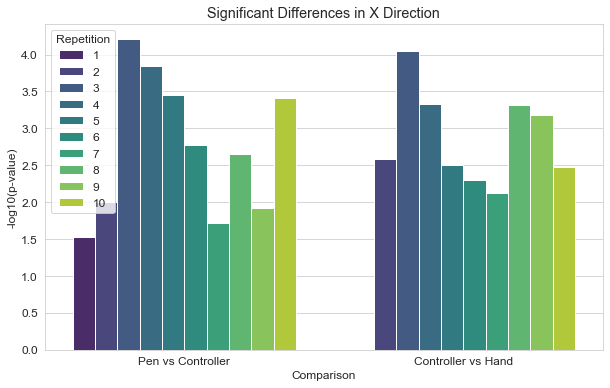

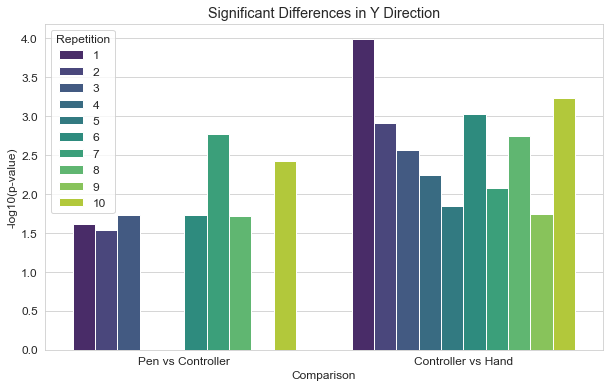

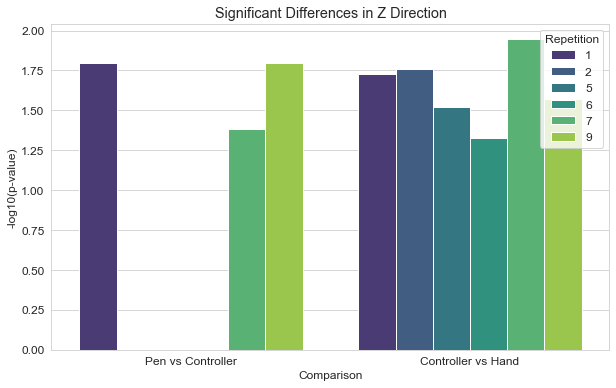

In [107]:
repetitions = df['Repetition'].unique()
results = []

for direction in directions:
    for channel in channels:
        for repetition in repetitions:
            controller_and_pen = df[(df['Object']=='Pen') & (df['Direction']==direction) & (df['Repetition']==repetition)][channel]
            two_controllers = df[(df['Object']=='Controller') & (df['Direction']==direction) & (df['Repetition']==repetition)][channel]
            two_hand = df[(df['Object']=='Hand') & (df['Direction']==direction) & (df['Repetition']==repetition)][channel]
            
            t_stat_1, p_val_1 = ss.ttest_ind(controller_and_pen, two_controllers)
            t_stat_2, p_val_2 = ss.ttest_ind(controller_and_pen, two_hand)
            t_stat_3, p_val_3 = ss.ttest_ind(two_controllers, two_hand)
            
            if p_val_1 < 0.05:
                results.append({
                    'Direction': direction,
                    'Channel': channel,
                    'Repetition': repetition,
                    'Comparison': 'Pen vs Controller',
                    't_stat': t_stat_1,
                    'p_val': p_val_1
                })
            
            if p_val_2 < 0.05:
                results.append({
                    'Direction': direction,
                    'Channel': channel,
                    'Repetition': repetition,
                    'Comparison': 'Pen vs Hand',
                    't_stat': t_stat_2,
                    'p_val': p_val_2
                })
            
            if p_val_3 < 0.05:
                results.append({
                    'Direction': direction,
                    'Channel': channel,
                    'Repetition': repetition,
                    'Comparison': 'Controller vs Hand',
                    't_stat': t_stat_3,
                    'p_val': p_val_3
                })

t_test_df = pd.DataFrame(results)
print(t_test_df)

t_test_df['-log10(p-value)'] = -np.log10(t_test_df['p_val'])

directions = ['X', 'Y', 'Z']

for direction in directions:
    plt.figure(figsize=(10,6))
    sns.barplot(data=t_test_df[t_test_df['Direction'] == direction], x='Comparison', y='-log10(p-value)', hue='Repetition', palette='viridis')
    plt.title(f'Significant Differences in {direction} Direction')
    plt.ylabel('-log10(p-value)')
    plt.show()

### Correlation


In [108]:
# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, columns=['Object', 'Direction'])

# Calculate correlation
corr_df = df_encoded.corr()

# Extract necessary correlations
object_dir_rep_corr = corr_df.loc[['Repetition', 'Object_Pen', 'Object_Controller', 'Object_Hand'],
                                  ['Direction_X', 'Direction_Y', 'Direction_Z']]

print(object_dir_rep_corr)

                    Direction_X   Direction_Y   Direction_Z
Repetition        -1.151580e-17  1.545158e-17 -8.964831e-18
Object_Pen         4.718448e-18  6.411538e-18  2.026157e-18
Object_Controller -8.104628e-18  1.704192e-17  8.965051e-18
Object_Hand       -4.329870e-18  9.492407e-18 -1.720846e-17


In [109]:
import statsmodels.formula.api as smf

# Create a DataFrame with the average fatigue index for each combination of subject, object, direction, and repetition
df_avg = df.groupby(['Subject', 'Object', 'Direction', 'Repetition'])['ChannelAvg'].mean().reset_index()

# Perform a linear regression with repetition, object, and direction as predictors of the fatigue index
model = smf.ols(formula='ChannelAvg ~ C(Object) + C(Direction) + Repetition', data=df_avg)
results = model.fit()

# Print the summary of the regression results
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:             ChannelAvg   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     57.50
Date:                Sun, 11 Jun 2023   Prob (F-statistic):           1.99e-56
Time:                        18:26:20   Log-Likelihood:                 4636.4
No. Observations:                2250   AIC:                            -9261.
Df Residuals:                    2244   BIC:                            -9226.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2285      0.00

In [73]:
# Convert objects to dummy variables
df_dummy = pd.get_dummies(df, columns=['Object'])

# Calculate correlation coefficients
correlations = df_dummy.corr()

# Extract correlations with ChannelAvg
channel_avg_correlations = correlations['ChannelAvg'].loc[['Object_Pen', 'Object_Controller', 'Object_Hand']]

# Print out correlations
print(channel_avg_correlations)


Object_Pen          -0.126129
Object_Controller    0.329455
Object_Hand         -0.203327
Name: ChannelAvg, dtype: float64


In [74]:
from scipy.stats import pearsonr

# Mapping categorical 'Object' data to numeric
object_mapping = {'Pen': 1, 'Controller': 2, 'Hand': 3}
df['ObjectNumerical'] = df['Object'].map(object_mapping)

# Calculate correlation
correlation, p_value = pearsonr(df['ObjectNumerical'], df['ChannelAvg'])

# Checking if the correlation is significant
if p_value < 0.05:
    print(f'Correlation between Object and ChannelAvg is significant at 95% level')
    print(f'Correlation coefficient is {correlation} and p-value is {p_value}')
else:
    print(f'Correlation between Object and ChannelAvg is not significant at 95% level')
    print(f'Correlation coefficient is {correlation} and p-value is {p_value}')

Correlation between Object and ChannelAvg is significant at 95% level
Correlation coefficient is -0.044570170986898645 and p-value is 0.034513171551857715


In [77]:
# Mapping categorical 'Object' data to numeric
Direction_mapping = {'X': 1, 'Y': 2, 'Z': 3}
df['DirectionNumerical'] = df['Direction'].map(Direction_mapping)

# Calculate correlation
correlation, p_value = pearsonr(df['DirectionNumerical'], df['ChannelAvg'])

# Checking if the correlation is significant
if p_value < 0.05:
    print(f'Correlation between Direction and ChannelAvg is significant at 95% level')
    print(f'Correlation coefficient is {correlation} and p-value is {p_value}')
else:
    print(f'Correlation between Direction and ChannelAvg is not significant at 95% level')
    print(f'Correlation coefficient is {correlation} and p-value is {p_value}')

Correlation between Direction and ChannelAvg is not significant at 95% level
Correlation coefficient is -0.04031767660479116 and p-value is 0.055856952113471525


In [78]:
# Mapping categorical 'Object' data to numeric
# Repetition_mapping = {'X': 1, 'Y': 2, 'Z': 3}
# df['RepetitionNumerical'] = df['Repetition'].map(object_mapping)

# Calculate correlation
correlation, p_value = pearsonr(df['Repetition'], df['ChannelAvg'])

# Checking if the correlation is significant
if p_value < 0.05:
    print(f'Correlation between Direction and ChannelAvg is significant at 95% level')
    print(f'Correlation coefficient is {correlation} and p-value is {p_value}')
else:
    print(f'Correlation between Direction and ChannelAvg is not significant at 95% level')
    print(f'Correlation coefficient is {correlation} and p-value is {p_value}')

Correlation between Direction and ChannelAvg is not significant at 95% level
Correlation coefficient is 0.009472614369125876 and p-value is 0.6533696642489055


### Multi-Factor ANOVA Test

In [ ]:
anova_model = ols('ChannelAvg ~ C(Object) + C(Direction)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
posthoc = pairwise_tukeyhsd(df['ChannelAvg'], df['Object'], alpha=0.05)
print(posthoc)
posthoc = pairwise_tukeyhsd(df['ChannelAvg'], df['Direction'], alpha=0.05)
print(posthoc)

In [ ]:
model = sm.OLS(df['ChannelAvg'], sm.add_constant(df['Repetition'])).fit()
print(model.summary())

In [ ]:
# Regression model with all channels as predictors
predictors = ['Channel'+str(i) for i in range(1, 9)]
model = sm.OLS(df['ChannelAvg'], sm.add_constant(df[predictors])).fit()
print(model.summary())


In [ ]:
sns.boxplot(x='Object', y='ChannelAvg', data=df)
plt.show()

In [ ]:
contingency_table = pd.crosstab(df['Object'], df['Direction'])
chi2, p, dof, expected = ss.chi2_contingency(contingency_table)
print("Chi-square statistic:", chi2)
print("p-value:", p)

In [ ]:
# List of subjects
subjects = df['Subject'].unique()

# List to store ChannelAvg values for each subject
data = [df[df['Subject'] == subject]['ChannelAvg'].values for subject in subjects]

# Kruskal-Wallis H-test
H, pval = ss.kruskal(*data)
print('Kruskal-Wallis H-statistic:', H)
print('p-value:', pval)

In [ ]:
repetitions = df['Repetition'].unique()

for direction in directions:
    for channel in channels:
        print(f'\nT-tests for {channel} RMS in {direction} direction:')
        for repetition in repetitions:
            controller_and_pen = df[(df['Object']=='ControllerAndPen') & (df['Direction']==direction) & (df['Repetition']==repetition)][channel]
            two_controllers = df[(df['Object']=='TwoControllers') & (df['Direction']==direction) & (df['Repetition']==repetition)][channel]
            two_hand = df[(df['Object']=='TwoHand') & (df['Direction']==direction) & (df['Repetition']==repetition)][channel]
            
            t_stat_1, p_val_1 = ss.ttest_ind(controller_and_pen, two_controllers)
            t_stat_2, p_val_2 = ss.ttest_ind(controller_and_pen, two_hand)
            t_stat_3, p_val_3 = ss.ttest_ind(two_controllers, two_hand)

            print(f'Repetition {repetition} - ControllerAndPen vs TwoControllers: t={t_stat_1}, p={p_val_1}')
            print(f'Repetition {repetition} - ControllerAndPen vs TwoHand: t={t_stat_2}, p={p_val_2}')
            print(f'Repetition {repetition} - TwoControllers vs TwoHand: t={t_stat_3}, p={p_val_3}')

In [ ]:
# Considering the RMS value of the first channel for simplicity. You can loop over channels.
df['RMS'] = df['ChannelAvg']

# Two-Way ANOVA considering interaction
model = ols('RMS ~ C(Object) + C(Repetition) + C(Object):C(Repetition)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

In [ ]:
sns.lineplot(data=df, x='Repetition', y='RMS_Slope', hue='Object')
plt.title('RMS Slope across Repetitions')
plt.xlabel('Repetition')
plt.ylabel('RMS Slope')
plt.show()

In [ ]:
df['Object'] = df['Object'].astype('category')
df['Direction'] = df['Direction'].astype('category')

In [ ]:
# ANOVA Test to see if there is a significant difference between groups (Object, Direction)
anova_object = ols('ChannelAvg ~ C(Object)', data=df).fit()
anova_table_object = sm.stats.anova_lm(anova_object, typ=2)
print(anova_table_object)

anova_direction = ols('ChannelAvg ~ C(Direction)', data=df).fit()
anova_table_direction = sm.stats.anova_lm(anova_direction, typ=2)
print(anova_table_direction)

# # Correlation Matrix for numerical columns | Show the correlation heatmap
# correlation_matrix = df.corr()
# print(correlation_matrix)
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()

# # Pairwise plots
# sns.pairplot(df, vars=["Repetition", "ChannelAvg"], hue="Object", height=5)
# sns.pairplot(df, vars=["Repetition", "ChannelAvg"], hue="Direction", height=5)
# plt.show()